In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
filepath = '/content/timeseriesdata.csv'
df = pd.read_csv(filepath)
df

,Quarter,hdbrpi,labour-cost,gdp,population,cpi,exchange-rate,consumer-spending,overall unemployment,sti
0,1990 1Q,24.3,74.7,"16,669.50","2,647,627",61.907,1.8843,16.113111,31600,1458.400000
1,1990 2Q,24.4,70.5,"17,087.70","2,677,041",62.501,1.8396,16.999927,31600,1527.000000
2,1990 3Q,25.0,73.8,"17,930.10","2,706,454",63.181,1.7632,17.886744,31600,1098.700000
3,1990 4Q,24.7,84.9,"18,805","2,735,868",63.969,1.7445,18.773560,31600,1154.800000
4,1991 1Q,24.9,80.5,"18,521","2,750,577",64.249,1.7931,19.660376,31600,1490.800000
...,...,...,...,...,...,...,...,...,...,...
91,2012 4Q,146.7,98.3,"94,848.80","3,818,205",97.936,1.2221,113.643019,63500,3167.080078
92,2013 1Q,148.6,101.0,"93,773","3,824,842",98.574,1.2436,114.828898,65700,3308.100098
93,2013 2Q,149.4,88.5,"95,587.20","3,831,478",97.656,1.2652,115.705388,67900,3150.439941
94,2013 3Q,148.1,89.3,"96,028.30","3,838,115",98.865,1.2572,116.581878,63300,3167.870117


In [5]:
def todatetime(row):
    row['Quarter'] = row['Quarter'].replace(' 1Q', '-03')
    row['Quarter'] = row['Quarter'].replace(' 2Q', '-06')
    row['Quarter'] = row['Quarter'].replace(' 3Q', '-09')
    row['Quarter'] = row['Quarter'].replace(' 4Q', '-12')
    
    return row

df1 = df.apply(todatetime, axis='columns')
df1['Quarter'] = pd.to_datetime(df1['Quarter'], infer_datetime_format = True)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Quarter               96 non-null     datetime64[ns]
 1   hdbrpi                96 non-null     float64       
 2   labour-cost           96 non-null     float64       
 3   gdp                   96 non-null     object        
 4   population            96 non-null     object        
 5   cpi                   96 non-null     float64       
 6   exchange-rate         96 non-null     float64       
 7   consumer-spending     96 non-null     float64       
 8   overall unemployment  96 non-null     int64         
 9   sti                   96 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 7.6+ KB


In [7]:
def tofloat(row):
    row['gdp'] = row['gdp'].replace(',', '')
    row['population'] = row['population'].replace(',', '')
    return row

df2 = df1.apply(tofloat, axis='columns')
df2['gdp'] = df2['gdp'].astype(float)
df2['population'] = df2['population'].astype(float)
df2['overall unemployment'] = df2['overall unemployment'].astype(float)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Quarter               96 non-null     datetime64[ns]
 1   hdbrpi                96 non-null     float64       
 2   labour-cost           96 non-null     float64       
 3   gdp                   96 non-null     float64       
 4   population            96 non-null     float64       
 5   cpi                   96 non-null     float64       
 6   exchange-rate         96 non-null     float64       
 7   consumer-spending     96 non-null     float64       
 8   overall unemployment  96 non-null     float64       
 9   sti                   96 non-null     float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 7.6 KB


In [8]:
df3 = df2.drop(columns = 'Quarter')
df3

,hdbrpi,labour-cost,gdp,population,cpi,exchange-rate,consumer-spending,overall unemployment,sti
0,24.3,74.7,16669.5,2647627.0,61.907,1.8843,16.113111,31600.0,1458.400000
1,24.4,70.5,17087.7,2677041.0,62.501,1.8396,16.999927,31600.0,1527.000000
2,25.0,73.8,17930.1,2706454.0,63.181,1.7632,17.886744,31600.0,1098.700000
3,24.7,84.9,18805.0,2735868.0,63.969,1.7445,18.773560,31600.0,1154.800000
4,24.9,80.5,18521.0,2750577.0,64.249,1.7931,19.660376,31600.0,1490.800000
...,...,...,...,...,...,...,...,...,...
91,146.7,98.3,94848.8,3818205.0,97.936,1.2221,113.643019,63500.0,3167.080078
92,148.6,101.0,93773.0,3824842.0,98.574,1.2436,114.828898,65700.0,3308.100098
93,149.4,88.5,95587.2,3831478.0,97.656,1.2652,115.705388,67900.0,3150.439941
94,148.1,89.3,96028.3,3838115.0,98.865,1.2572,116.581878,63300.0,3167.870117


In [9]:
df4 = df3.hdbrpi
df4.shape

(96,)

In [10]:
data = df4.to_numpy()
data.shape

(96,)

In [11]:
num_features = 1
data = data.reshape((len(data), num_features))
data.shape

(96, 1)

In [12]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, data, test_size=0.2, random_state=0, shuffle=False)

In [30]:
win_length = 6
print(Xtrain.shape)
print(Xtest.shape)

(76, 1)
(20, 1)


In [31]:
train_generator = TimeseriesGenerator(Xtrain, Ytrain, length=win_length, sampling_rate=1, batch_size=96)
test_generator = TimeseriesGenerator(Xtest, Ytest, length=win_length, sampling_rate=1, batch_size=96)

In [32]:
X_train = train_generator[0][0]
Y_train = train_generator[0][1]
X_test = test_generator[0][0]
Y_test = test_generator[0][1]
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(70, 6, 1)
(70, 1)
(14, 6, 1)
(14, 1)


In [33]:
print(len(X_train))

70


In [44]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(16, activation='relu', input_shape=(win_length, num_features), return_sequences=False))
#model.add(tf.keras.layers.LSTM(10, activation='relu', return_sequences=True))
#model.add(tf.keras.layers.LSTM(16, activation='relu', return_sequences=True))
#model.add(tf.keras.layers.LSTM(10, activation='relu', return_sequences=True))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.LSTM(6, activation='relu', return_sequences=False))
model.add(tf.keras.layers.Dense(1))

In [45]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(X_train, Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=6)

Epoch 1/200
12/12 [==============================] - 1s 29ms/step - loss: 1972.2730 - mean_absolute_error: 39.9418 - val_loss: 2756.7827 - val_mean_absolute_error: 52.4188
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 317.8132 - mean_absolute_error: 14.2539 - val_loss: 440.7782 - val_mean_absolute_error: 20.8923
Epoch 3/200
12/12 [==============================] - 0s 7ms/step - loss: 69.9804 - mean_absolute_error: 6.5035 - val_loss: 42.5474 - val_mean_absolute_error: 6.0676
Epoch 4/200
12/12 [==============================] - 0s 7ms/step - loss: 53.5407 - mean_absolute_error: 5.9125 - val_loss: 52.5830 - val_mean_absolute_error: 6.8952
Epoch 5/200
12/12 [==============================] - 0s 7ms/step - loss: 49.0651 - mean_absolute_error: 5.4069 - val_loss: 10.7187 - val_mean_absolute_error: 2.4924
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 53.8094 - mean_absolute_error: 5.2926 - val_loss: 11.9534 - val_mean_absolute_error: 2.4126

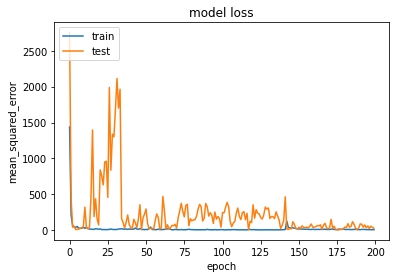

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
print("train MSE", min(history.history['loss']))
print("val MSE", min(history.history['val_loss']))

train MSE 4.678847312927246
val MSE 4.999792575836182


In [48]:
print("train MSE", history.history['loss'][-1])
print("val MSE", history.history['val_loss'][-1])

train MSE 7.434532642364502
val MSE 27.89261245727539


In [49]:
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [50]:
X, Y = prepare_data(data, 5)

In [51]:
Y_pred = model.predict(X)
Y_pred.shape

(91, 1)

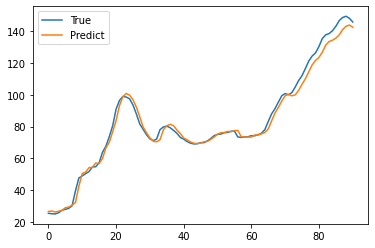

In [52]:
plt.plot(Y, label='True')
plt.plot(Y_pred,  label='Predict')
plt.legend()
plt.show()

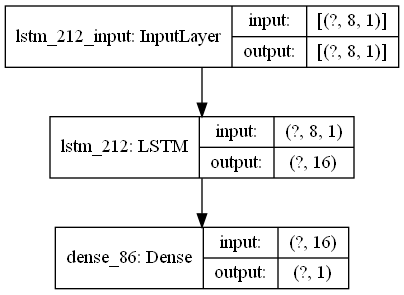

In [ ]:
tf.keras.utils.plot_model(model, to_file='model2.png', show_shapes=True)